# Agenda

#### 1- Parameterized circuit
#### 2- Variational Quantum Eigensolver (VQE): QAOA and UCCSD
#### 3- Generative Pre-training Transformer- Quantum Eigensolver (GPT-QE)

### 1- Parameterized circuit:

In [1]:
import cudaq
from cudaq import spin

cudaq.set_target("nvidia")

@cudaq.kernel
def param_circuit(theta: list[float]):
    # Allocate a qubit that is initialised to the |0> state.
    qubit = cudaq.qubit()
    # Define gates and the qubits they act upon.
    rx(theta[0], qubit)
    ry(theta[1], qubit)


# Our hamiltonian will be the Z expectation value of our qubit.
hamiltonian = spin.z(0)

# Initial gate parameters which initialize the qubit in the zero state
parameters = [0.0, 0.0]

print(cudaq.draw(param_circuit,parameters))

# Compute the expectation value using the initial parameters.
expectation_value = cudaq.observe(param_circuit, hamiltonian,parameters).expectation()

print('Expectation value of the Hamiltonian: ', expectation_value)

     ╭───────╮╭───────╮
q0 : ┤ rx(0) ├┤ ry(0) ├
     ╰───────╯╰───────╯

Expectation value of the Hamiltonian:  1.0


### 2- Variational quantum eignsolver:

<div>
<img src="./VQE.png" width="800">
</div>

### 1. VQA using ```cudaq.observe()``` & classical optimizer.

There are three ways to run VQE in CUDA-Q:

- Using cudaq built-in optimizer

In [13]:
import cudaq
from cudaq import spin

cudaq.set_target("nvidia")

@cudaq.kernel
def vqe_circuit(theta: list[float]):
    # Allocate a qubit that is initialised to the |0> state.
    qubit = cudaq.qubit()
    # Define gates and the qubits they act upon.
    rx(theta[0], qubit)
    ry(theta[1], qubit)


# Our hamiltonian will be the Z expectation value of our qubit.
hamiltonian = spin.z(0)

# Initial gate parameters which initialize the qubit in the zero state
initial_param = [0.0, 0.0]

cost_values = []

def cost(parameters):
    """Returns the expectation value as our cost."""
    expectation_value = cudaq.observe(vqe_circuit, hamiltonian, parameters).expectation()
    cost_values.append(expectation_value)
    return expectation_value

initial_cost_value = cost(initial_param)
print('Initial cost value: ', initial_cost_value)
print('Initial parameters: ', initial_param)

# Define a CUDA-Q optimizer.
optimizer = cudaq.optimizers.COBYLA()
optimizer.initial_parameters = initial_param

result = optimizer.optimize(dimensions=2, function=cost)

print('Final cost value: ', result[0])
print('Optimized parameters: ', result[1])


Initial cost value:  1.0
Initial parameters:  [0.0, 0.0]
Final cost value:  -0.9999999999999981
Optimized parameters:  [3.141592653589793, 0.0]


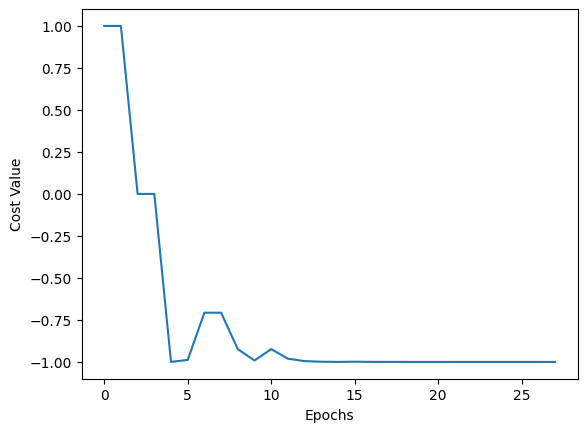

In [14]:
import matplotlib.pyplot as plt

x_values = list(range(len(cost_values)))
y_values = cost_values

plt.plot(x_values, y_values)

plt.xlabel("Epochs")
plt.ylabel("Cost Value")
plt.show()

- using third-party optimizer: ex. scipy optimizer

In [2]:
import cudaq
from cudaq import spin
import scipy

cudaq.set_target("nvidia")

@cudaq.kernel
def vqe_circuit_scipy(theta: list[float]):
    # Allocate a qubit that is initialised to the |0> state.
    qubit = cudaq.qubit()
    # Define gates and the qubits they act upon.
    rx(theta[0], qubit)
    ry(theta[1], qubit)

# Our hamiltonian will be the Z expectation value of our qubit.
hamiltonian = spin.z(0)

# Initial gate parameters which initialize the qubit in the zero state
initial_parameters = [0.0, 0.0]

def cost_scipy(parameters):
    """Returns the expectation value as our cost."""
    expectation_value = cudaq.observe(vqe_circuit_scipy, hamiltonian, parameters).expectation()
    return expectation_value

initial_cost_value = cost_scipy(initial_parameters)
print('Initial cost value: ', initial_cost_value)
print('Initial parameters: ', initial_parameters)


result = scipy.optimize.minimize(cost_scipy,initial_parameters,method='COBYLA')

print('Final cost value: ', result.fun)
print('Optimized parameters: ', result.x)

Initial cost value:  1.0
Initial parameters:  [0.0, 0.0]
Final cost value:  -0.9999999971782676
Optimized parameters:  [ 3.14169124e+00 -3.96734218e-05]


- VQE wrapper: combine ```cudaq.observe()``` and the optimizer

In [3]:
import cudaq
from cudaq import spin

cudaq.set_target("nvidia")

@cudaq.kernel
def vqe_circuit(theta: list[float]):
    # Allocate a qubit that is initialised to the |0> state.
    qubit = cudaq.qubit()
    # Define gates and the qubits they act upon.
    rx(theta[0], qubit)
    ry(theta[1], qubit)


# Our hamiltonian will be the Z expectation value of our qubit.
hamiltonian = spin.z(0)

# Initial gate parameters which initialize the qubit in the zero state
initial_param = [0.0, 0.0]

optimizer = cudaq.optimizers.COBYLA()
optimizer.max_iterations = 30
optimizer.initial_parameters=initial_param

opt_value, opt_theta = cudaq.vqe(kernel=vqe_circuit, 
                         spin_operator=hamiltonian,
                         optimizer=optimizer,
                         parameter_count=len(initial_param))

print(f"\nminimized <H> = {round(opt_value,16)}")
print(f"optimal theta = {opt_theta}")


minimized <H> = -0.9999999999999981
optimal theta = [3.141592653589793, 0.0]


### Example: VQE-QAOA algorithm

<div>
<img src="./QAOA.png" width="800">
</div>

- #### Max-Cut problem:

Each of these cuts below partitions the graph into two disjoint sets. The cut on the left is not optimal, and the cut on the right is the max cut. The cut on the left divides the graph into disjoint sets {1,2}  and {0,3,4}, and that cut contains 3 edges. To more easily visualize the cut, we have colored the vertices in one set of the partition green and the vertices in the other set of the partition gray. The cut depicted in the diagram on the right divides the graph vertices into two disjoint sets {0,2}, colored gray, and {1,3,4}, colored green.

<div>
<img src="./maxcut.png" width="800">
</div>

For the graph on the right, the number of edges in the cut (in this case there are  edges) is maximal, and this value is referred to as the max cut value.

The max cut solutions are 01011, 10100, 01010, 10101 


In [4]:
import cudaq
from cudaq import spin
import numpy as np

cudaq.set_target('nvidia')


nodes: list[int] = [0, 1, 2, 3, 4]
edges = [[0, 1], [1, 2], [2, 3], [3, 0], [2, 4], [3, 4]]
edges_src: list[int] = [edges[i][0] for i in range(len(edges))]
edges_tgt: list[int] = [edges[i][1] for i in range(len(edges))]

qubit_count: int = len(nodes)
layer_count: int = 2
parameter_count: int = 2 * layer_count

- #### Hamiltonian for Max-Cut problem:
$$
H= \frac{1}{2} \sum_{u,v} \left(Z_u Z_v - I_u I_v\right)
$$

In [5]:
def hamiltonian_max_cut(edges_src, edges_tgt):
    
    hamiltonian = 0

    for edge in range(len(edges_src)):

        qubitu = edges_src[edge]
        qubitv = edges_tgt[edge]
        # Add a term to the Hamiltonian for the edge (u,v)
        hamiltonian += 0.5 * (spin.z(qubitu) * spin.z(qubitv) -
                              spin.i(qubitu) * spin.i(qubitv))

    return hamiltonian

# Generate the Hamiltonian for our graph
hamiltonian = hamiltonian_max_cut(edges_src, edges_tgt)
print(hamiltonian)

[0.5+0j] IIZIZ
[0.5+0j] IZZII
[-3+0j] IIIII
[0.5+0j] ZZIII
[0.5+0j] IIIZZ
[0.5+0j] IIZZI
[0.5+0j] ZIIZI



Implementation of the elements of mixer (left) and cost (right) layers based on the cost and mixer Hamiltonians

<div>
<img src="./prob-mixer.png"   width=800>
</div>

In [6]:
@cudaq.kernel
def qaoaProblem(qubit_0: cudaq.qubit, qubit_1: cudaq.qubit, alpha: float):
    x.ctrl(qubit_0, qubit_1)
    rz(2.0 * alpha, qubit_1)
    x.ctrl(qubit_0, qubit_1)

@cudaq.kernel
def kernel_qaoa(qubit_count: int, layer_count: int, edges_src: list[int],
                edges_tgt: list[int], thetas: list[float]):

    # Let's allocate the qubits
    qreg = cudaq.qvector(qubit_count)
    # And then place the qubits in superposition
    h(qreg)

    # Each layer has two components: the problem kernel and the mixer
    for i in range(layer_count):
        # Add the problem kernel to each layer
        for edge in range(len(edges_src)):
            qubitu = edges_src[edge]
            qubitv = edges_tgt[edge]
            qaoaProblem(qreg[qubitu], qreg[qubitv], thetas[i])
        # Add the mixer kernel to each layer
        for j in range(qubit_count):
            rx(2.0 * thetas[i + layer_count], qreg[j])

- #### Optimize to find the optimum circuit parameters that will minimize the Hamiltonian

In [7]:
# Specify the optimizer and its initial parameters.
cudaq.set_random_seed(13)
optimizer = cudaq.optimizers.NelderMead()
np.random.seed(13)
optimizer.initial_parameters = np.random.uniform(-np.pi / 8, np.pi / 8,
                                                 parameter_count)
print("Initial parameters = ", optimizer.initial_parameters)


def objective(parameters):
    return cudaq.observe(kernel_qaoa, hamiltonian, qubit_count, layer_count,
                         edges_src, edges_tgt, parameters).expectation()


#Optimize!
optimal_expectation, optimal_parameters = optimizer.optimize(
    dimensions=parameter_count, function=objective)

print('optimal_expectation =', optimal_expectation)
print('Therefore, the max cut value is at least ', -1 * optimal_expectation)
print('optimal_parameters =', optimal_parameters)

Initial parameters =  [0.21810696323572243, -0.20613464375211488, 0.2546877639814583, 0.3657985647468064]
optimal_expectation = -4.495974808931351
Therefore, the max cut value is at least  4.495974808931351
optimal_parameters = [0.5134562006629528, -0.21296600238693275, 0.32497261325857235, 0.8866578108675061]


- #### Let's sample the circuit using the optimum parameters and find the cut with the highest probability:

In [9]:
counts = cudaq.sample(kernel_qaoa, qubit_count, layer_count, edges_src,
                      edges_tgt, optimal_parameters, shots_count=50000)
print(counts)

# Identify the most likely outcome from the sample
print('The max cut is given by the partition: ',
      max(counts, key=lambda x: counts[x]))

# Alternatively
print('Most probable bit string: ', counts.most_probable())  

{ 11111:145 01111:111 01010:7600 01110:2258 01101:288 10010:305 00010:86 11010:254 00100:90 00110:3132 10101:7652 11000:245 01000:99 00111:339 11100:223 10111:102 10000:94 11011:91 10100:7692 10110:2330 11110:60 00001:53 10001:2333 00000:141 01001:2267 11101:93 11001:3064 00101:228 01011:7751 00011:243 01100:308 10011:323 }

The max cut is given by the partition:  01011
Most probable bit string:  01011


- #### Maximum vertex weigh clique problem (MVWCP): Molecular docking problem (see [this paper](https://arxiv.org/pdf/2308.04098) )

<div>
<img src="./molecular-docking.png" width="800">
</div>

In [2]:
import cudaq
from cudaq import spin
import numpy as np

# GPU: Default If an NVIDIA GPU and CUDA runtime libraries are available
cudaq.set_target('nvidia')

# CPU
#cudaq.set_target('qpp-cpu')

# The two graphs input from the paper

# BIG 1

nodes = [0,1,2,3,4,5]
qubit_num=len(nodes)
edges = [[0,1],[0,2],[0,4],[0,5],[1,2],[1,3],[1,5],[2,3],[2,4],[3,4],[3,5],[4,5]]
non_edges = [[u,v] for u in nodes for v in nodes if u<v and [u,v] not in edges]
print('Edges: ', edges)
print('Non-Edges: ', non_edges)
weights = [0.6686,0.6686,0.6686,0.1453,0.1453,0.1453]
penalty = 6.0
num_layers = 3

# BIG 2 (More expensive simulation)

#nodes=[0,1,2,3,4,5,6,7]
#qubit_num=len(nodes)
#edges=[[0,1],[0,2],[0,5],[0,6],[0,7],[1,2],[1,4],[1,6],[1,7],[2,4],[2,5],[2,7],[3,4],[3,5],[3,6],\
#    [4,5],[4,6],[5,6]]
#non_edges=[[u,v] for u in nodes for v in nodes if u<v and [u,v] not in edges]
#print('Edges: ', edges)
#print('Non-edges: ', non_edges)
#weights=[0.6686,0.6686,0.6886,0.1091,0.0770,0.0770,0.0770,0.0770]
#penalty=8.0
#num_layers=8

Edges:  [[0, 1], [0, 2], [0, 4], [0, 5], [1, 2], [1, 3], [1, 5], [2, 3], [2, 4], [3, 4], [3, 5], [4, 5]]
Non-Edges:  [[0, 3], [1, 4], [2, 5]]


### Hamiltonian for MVWCP:

$$
H_c = \frac{1}{2} \sum_i \omega_i (\sigma_z^i - I_i) + \frac{P}{4} \sum_{(i,j)} (\sigma_z^i - I_i) (\sigma_z^j - I_j)
$$

In [2]:
# Generate the Hamiltonian
def ham_clique(penalty, nodes, weights, non_edges)-> cudaq.SpinOperator:

    spin_ham = 0.0
    for wt,node in zip(weights,nodes):
        #print(wt,node)
        spin_ham += 0.5 * wt * spin.z(node)
        spin_ham -= 0.5 * wt * spin.i(node)

    for non_edge in non_edges:
        u,v=(non_edge[0],non_edge[1])
        #print(u,v)
        spin_ham += penalty/4.0 * (spin.z(u)*spin.z(v)-spin.z(u)-spin.z(v)+spin.i(u)*spin.i(v))

    return spin_ham

ham= ham_clique(penalty,nodes,weights,non_edges)
print(ham)

[1.5+0j] IIZIIZ
[1.5+0j] ZIIZII
[-1.1657+0j] IZIIII
[1.5+0j] IZIIZI
[-1.42735+0j] IIIZII
[3.2791499999999996+0j] IIIIII
[-1.1657+0j] IIZIII
[-1.42735+0j] IIIIIZ
[-1.1657+0j] ZIIIII
[-1.42735+0j] IIIIZI



#### Pauli word & ```exp_pauli()```:

Pauli words are tensor products of the single-qubit X, Y, Z, I Pauli operators (P). Exponentiating these operators $(e^{-i\theta P})$ results in single qubit rotation gates: $Rx(\theta), Ry(\theta), Rz(\theta)$.

Certain algorithms require more complex operations derived from the exponentiation of whole Pauli words.

CUDA-Q v0.8 now includes a new pauli_word type that can be input to a quantum kernel and converted into a quantum circuit operation with exp_pauli.  The following code example shows how a list of Pauli words and their associated coefficients can be used to apply the following operation: 

<div>
<img src="./prob-mixer.png"   width=800>
</div>

In [3]:
# Collect coefficients from a spin operator so we can pass them to a kernel
def term_coefficients(ham: cudaq.SpinOperator) -> list[complex]:
    result = []
    ham.for_each_term(lambda term: result.append(term.get_coefficient()))
    return result

    # Collect Pauli words from a spin operator so we can pass them to a kernel
def term_words(ham: cudaq.SpinOperator) -> list[str]:
    result = []
    ham.for_each_term(lambda term: result.append(term.to_string(False)))
    return result

coef=term_coefficients(ham)
words=term_words(ham)

print(term_coefficients(ham))
print(term_words(ham))

[(1.5+0j), (1.5+0j), (-1.1657+0j), (1.5+0j), (-1.42735+0j), (3.2791499999999996+0j), (-1.1657+0j), (-1.42735+0j), (-1.1657+0j), (-1.42735+0j)]
['IIZIIZ', 'ZIIZII', 'IZIIII', 'IZIIZI', 'IIIZII', 'IIIIII', 'IIZIII', 'IIIIIZ', 'ZIIIII', 'IIIIZI']


In [4]:
@cudaq.kernel
def dc_qaoa(qubit_num:int, num_layers:int,thetas:list[float],\
    coef:list[complex], words:list[cudaq.pauli_word]):

    qubits=cudaq.qvector(qubit_num)

    h(qubits)

    count=0
    for p in range(num_layers):

        for i in range(len(coef)):
            exp_pauli(thetas[count]*coef[i].real,qubits,words[i])
            count+=1

        for j in range(qubit_num):
            rx(thetas[count],qubits[j])
            count+=1

        for k in range(qubit_num):
            ry(thetas[count],qubits[k])
            count+=1

In [5]:
# Optimizer

# Specify the optimizer and its initial parameters.
optimizer = cudaq.optimizers.NelderMead()

np.random.seed(13)
cudaq.set_random_seed(13)

# Number of parameters in multi-angle DC-QAOA
parameter_count=(2*qubit_num+len(coef))*num_layers
print('Total number of parameters: ', parameter_count)

# Initialize parameters randomly
optimizer.initial_parameters = np.random.uniform(-np.pi/8 , np.pi/8 ,parameter_count)
print("Initial parameters = ", optimizer.initial_parameters)

Total number of parameters:  66
Initial parameters =  [0.21810696323572243, -0.20613464375211488, 0.2546877639814583, 0.3657985647468064, 0.37118004688049144, -0.03656087558321203, 0.08564174998504231, 0.21639801853794682, 0.11122286088634259, 0.1743727097033635, -0.36518146001762486, -0.15829741539542244, -0.3467434780387345, 0.28043500852894776, -0.09986021299050934, 0.14125225086023052, -0.19141728018199775, -0.11970943368650361, -0.3853063093646483, -0.1112643868789806, 0.3527177454825464, -0.22156160012057186, -0.1418496891385843, 0.32811766468303116, -0.367642000671186, -0.34158180583996006, 0.10196745745501312, 0.29359239180502594, -0.3858537615546677, 0.19366130907065582, 0.24570488114056754, -0.3332307385378807, 0.12287973244618389, 0.007274514934614895, -0.015799547372526146, 0.3578070967202224, -0.39268963055535144, -0.19872246354138554, 0.16668715544467982, -0.13777293592446055, -0.17514665212709513, 0.15350249947988204, 0.32872977428061945, -0.20068831419712105, -0.0329193

In [6]:
cost_values=[]
def objective(parameters):

    cost=cudaq.observe(dc_qaoa, ham, qubit_num, num_layers, parameters,coef,words).expectation()
    cost_values.append(cost)
    return cost

# Optimize!
optimal_expectation, optimal_parameters = optimizer.optimize(
    dimensions=parameter_count, function=objective)

print('optimal_expectation =', optimal_expectation)
print('optimal_parameters =', optimal_parameters)

optimal_expectation = -2.0056562047037554
optimal_parameters = [2.07462732172167, 0.0836129387511666, 0.732466832498772, 0.993760756630795, 0.6612983192449209, 0.254995629840188, 0.46730416793692564, 0.31817890808955307, 0.2681330612438232, -0.05317941374207889, -1.5707161782942043, 1.6673255396619224, -1.2020555642055013, 0.7010711599376453, -0.7074160338811271, 0.16417319418578918, 0.19391752827664988, -0.07226097507350732, 0.13177621888364366, -0.5863964692039323, 0.438045876501409, -0.7661788437090172, 0.05129909802935419, -0.014613176135278728, 2.113643328197025, 1.8618008437639477, 0.24617399493654818, 0.3993080640402272, 1.635255899393869, -0.5636658425315497, 0.47404201081294284, -1.1976460602439467, 0.48906415004867176, 0.2218455299383959, 0.8811545861559398, 1.2100012187675642, -0.8533386705183392, -0.30908718640500593, 0.38800102862311536, 0.19338421747706744, -0.2327165217461496, -0.17466834745930265, -0.26310097350628137, -0.5969362694470881, 0.17591962008385534, 2.1964126

In [7]:
shots=50000

counts = cudaq.sample(dc_qaoa, qubit_num, num_layers, optimal_parameters,coef,words, shots_count=shots)
print(counts)

print('The MVWCP is given by the partition: ', max(counts, key=lambda x: counts[x]))

# Alternative
print('The MVWCP is given by the partition: ', counts.most_probable())

{ 101010:7 011100:6 111000:49987 }

The MVWCP is given by the partition:  111000
The MVWCP is given by the partition:  111000


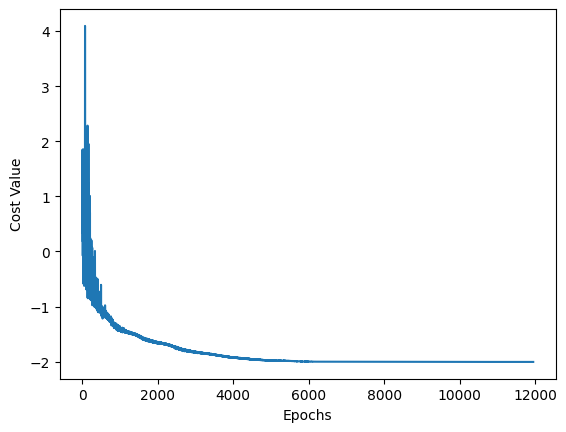

In [8]:
import matplotlib.pyplot as plt

x_values = list(range(len(cost_values)))
y_values = cost_values

plt.plot(x_values, y_values)

plt.xlabel("Epochs")
plt.ylabel("Cost Value")
plt.show()

## Examples: VQE-UCCSD

- #### Find the ground state energy for H2 molecule.

In [21]:
# pip install openfermionpyscf
# python H2-full-space.py

import cudaq 

cudaq.set_target("nvidia", option="fp64")

hydrogen_count = 2
bond_distance = 0.7474
geometry = [('H', (0, 0, i * bond_distance)) for i in range(hydrogen_count)]

molecule, data = cudaq.chemistry.create_molecular_hamiltonian(geometry, 'sto-3g', 1, 0)
electron_count = data.n_electrons
qubit_count = 2 * data.n_orbitals

@cudaq.kernel
def kernel(thetas: list[float]):
    qubits = cudaq.qvector(qubit_count)
    
    # Prepare the Hartree Fock State.
    for i in range(electron_count):
        x(qubits[i])

    # UCCSD ansatz
    cudaq.kernels.uccsd(qubits, thetas, electron_count, qubit_count)

parameter_count = cudaq.kernels.uccsd_num_parameters(electron_count, qubit_count)
optimizer = cudaq.optimizers.COBYLA()
energy, parameters = cudaq.vqe(kernel, molecule, optimizer, parameter_count=parameter_count)
print('VQE-UCCSD energy= ', energy)
print('Final parameters: ', parameters)

# Let's look at the state
state=np.array(cudaq.get_state(kernel,parameters))
print('Final state coefficients= ', state)

for i in range(len(state)):
    if abs(state[i])>0.1:
        print('state, coefficient= ', [i, bin(i).replace("0b", "")], state[i])

VQE-UCCSD energy=  -1.1371756649403286
Final parameters:  [-0.0003704384194332785, 0.000381111016414357, 0.22868237965329047]
Final state coefficients=  [ 2.77555756e-17-5.03069808e-17j -2.60208521e-17+2.77555756e-17j
  5.20417043e-18-2.77555756e-17j  9.93470126e-01+1.90819582e-17j
 -4.33680869e-18+1.39048929e-17j  2.77555756e-17-8.76035355e-17j
 -1.85219205e-04-8.58688121e-17j  2.34187669e-17-6.93618340e-17j
 -1.38777878e-17+1.04354459e-17j -1.90555504e-04-2.77555756e-17j
  5.89805982e-17+1.38777878e-17j  2.77555756e-17-1.73201297e-17j
 -1.14092236e-01+4.16333634e-17j  2.77555756e-17+3.46944695e-18j
 -2.77555756e-17+2.08166817e-17j -4.51028104e-17+4.16333634e-17j]
state, coefficient=  [3, '11'] (0.9934701259073868+1.908195823574488e-17j)
state, coefficient=  [12, '1100'] (-0.11409223598475848+4.163336342344337e-17j)


- #### Find the ground state energy of water using active space.

<div>
<img src="./active-space.png" width="800">
</div>

In [19]:
# pip install openfermionpyscf
# pip install openfermion
# python water-active-space.py 

import openfermion
import openfermionpyscf
from openfermion.transforms import jordan_wigner, get_fermion_operator

import cudaq
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import numpy as np

# GPU
cudaq.set_target('nvidia', option='fp64')

# CPU
#cudaq.set_target("qpp-cpu")

# 1- Classical pre-processing:
geometry=[('O', (0.1173,0.0,0.0)), ('H', (-0.4691,0.7570,0.0)), ('H', (-0.4691,-0.7570,0.0))]
basis='sto3g'
multiplicity=1
charge=0
ncore=3
norb_cas, nele_cas = (3,4)

# Run HF to obtain the HF molecular orbitals and compute the one and two electron integrals
molecule = openfermionpyscf.run_pyscf(openfermion.MolecularData(geometry, basis, multiplicity,charge))

# Generate the active space Hamiltonian 
molecular_hamiltonian = molecule.get_molecular_hamiltonian(
        occupied_indices=range(ncore), active_indices=range(ncore,ncore+norb_cas))

fermion_hamiltonian = get_fermion_operator(molecular_hamiltonian)
qubit_hamiltonian = jordan_wigner(fermion_hamiltonian)

spin_ham=cudaq.SpinOperator(qubit_hamiltonian)

print('Total number of terms in the spin hamiltonian: ',spin_ham.get_term_count())

Total number of terms in the spin hamiltonian:  62


/tmp/ipykernel_43163/3373463660.py:38: ComplexWarning: Casting complex values to real discards the imaginary part
  spin_ham=cudaq.SpinOperator(qubit_hamiltonian)


In [20]:
# 2- Quantum computing using UCCSD ansatz

electron_count=nele_cas
qubit_count=2*norb_cas

@cudaq.kernel
def kernel(qubit_num:int, electron_num:int, thetas: list[float]):
        qubits = cudaq.qvector(qubit_num)

        # Initialize the qubit: HF state
        for i in range(electron_num):
                x(qubits[i])

        cudaq.kernels.uccsd(qubits, thetas, electron_num, qubit_num)

parameter_count = cudaq.kernels.uccsd_num_parameters(electron_count,qubit_count)

# Define a function to minimize
def cost(theta):

        exp_val = cudaq.observe(kernel, spin_ham, qubit_count, electron_count, theta).expectation()

        return exp_val


exp_vals = []

def callback(xk):
        exp_vals.append(cost(xk))


# Initial variational parameters.
np.random.seed(42)
x0 = np.random.normal(0, 1, parameter_count)

# Use the scipy optimizer to minimize the function of interest

result = minimize(cost,x0,method='COBYLA',callback=callback, tol=1e-8)


print('UCCSD-VQE energy=  ', result.fun)
print('Total number of qubits: ', qubit_count)
print('Total number of parameters: ', parameter_count)

UCCSD-VQE energy=   -74.96735864574195
Total number of qubits:  6
Total number of parameters:  8


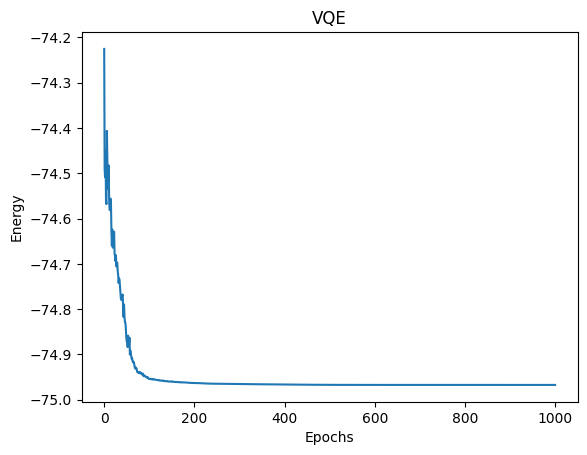

In [21]:
plt.plot(exp_vals)
plt.xlabel('Epochs')
plt.ylabel('Energy')
plt.title('VQE')
plt.show()

- #### With parameter shift to compute gradient

<div>
<img src="./param-shift.png" width="500">
</div>


In [22]:
import openfermion
import openfermionpyscf
from openfermion.transforms import jordan_wigner, get_fermion_operator

import cudaq
from scipy.optimize import minimize
import numpy as np

# GPU
cudaq.set_target("nvidia", option="fp64")

# 1- Classical pre-processing:
geometry=[('O', (0.1173,0.0,0.0)), ('H', (-0.4691,0.7570,0.0)), ('H', (-0.4691,-0.7570,0.0))]
basis='sto3g'
multiplicity=1
charge=0
ncore=3
norb_cas, nele_cas = (3,4)

molecule = openfermionpyscf.run_pyscf(openfermion.MolecularData(geometry, basis, multiplicity,charge))

molecular_hamiltonian = molecule.get_molecular_hamiltonian(
        occupied_indices=range(ncore), active_indices=range(ncore,ncore+norb_cas))

fermion_hamiltonian = get_fermion_operator(molecular_hamiltonian)
qubit_hamiltonian = jordan_wigner(fermion_hamiltonian)

spin_ham=cudaq.SpinOperator(qubit_hamiltonian)
print('Total number of terms in the spin hamiltonian: ',spin_ham.get_term_count())

Total number of terms in the spin hamiltonian:  62


/tmp/ipykernel_43163/1775979460.py:28: ComplexWarning: Casting complex values to real discards the imaginary part
  spin_ham=cudaq.SpinOperator(qubit_hamiltonian)


In [23]:
# 2- Quantum computing using UCCSD ansatz
electron_count=nele_cas
qubit_count=2*norb_cas

@cudaq.kernel
def kernel(qubit_num:int, electron_num:int, thetas: list[float]):
        qubits = cudaq.qvector(qubit_num)

        for i in range(electron_num):
                x(qubits[i])

        cudaq.kernels.uccsd(qubits, thetas, electron_num, qubit_num)

parameter_count = cudaq.kernels.uccsd_num_parameters(electron_count,qubit_count)

gradient = cudaq.gradients.ParameterShift()

exp_ham=[]
def objective_function(parameter_vector: list[float], \
                       gradient=gradient, hamiltonian=spin_ham, kernel=kernel):


    get_result = lambda parameter_vector: cudaq.observe\
        (kernel, hamiltonian, qubit_count, electron_count, parameter_vector).expectation()
    
    cost = get_result(parameter_vector)
    exp_ham.append(cost)
    gradient_vector = gradient.compute(parameter_vector, get_result,cost)
    
    return cost, gradient_vector

# Initial variational parameters.
np.random.seed(42)
init_params = np.random.normal(0, 1, parameter_count)
result_vqe=minimize(objective_function,init_params, method='L-BFGS-B', jac=True, tol=1e-8)

print('VQE-UCCSD energy= ', result_vqe.fun)
print('Total number of parameters: ', parameter_count)

VQE-UCCSD energy=  -74.96738405916265
Total number of parameters:  8


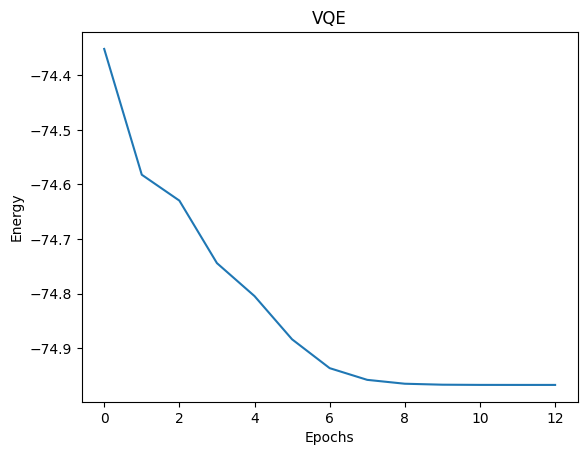

In [24]:
plt.plot(exp_ham)
plt.xlabel('Epochs')
plt.ylabel('Energy')
plt.title('VQE')
plt.show()

### * Notice the number of VQE iterations is drastically lower.

- ### Gate Fusion:

Gate fusion is an optimization technique where consecutive quantum gates are combined or merged into a single gate to reduce the overall computational cost and improve circuit efficiency. The number of gates combined (gate fusion level) can significantly affect simulation performance and needs to be optimized for every application. You can now adjust the ```CUDAQ_MGPU_FUSE``` parameter and specify custom gate fusion levels different

<div>
<img src="./gate-fuse.png" width="800">
</div>

- #### Perfomance: with and without gate fusion
<div>
<img src="./gate-fuse-performance.png" width="800">
</div>


Look at this [blog](https://developer.nvidia.com/blog/new-nvidia-cuda-q-features-boost-quantum-application-performance/) to learn more.

- #### Other available environment variables:

```CUDAQ_FUSION_MAX_QUBITS```; ```CUDAQ_FUSION_DIAGONAL_GATE_MAX_QUBITS```; ... etc.

To learn more, see [this page](https://nvidia.github.io/cuda-quantum/latest/using/backends/simulators.html#nvidia-fp64-backend) on cudaq doc


#### Example: C2H4 molecule with 24 qubits

``` python
import openfermion
import openfermionpyscf
from openfermion.transforms import jordan_wigner, get_fermion_operator

import timeit


import cudaq
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import numpy as np

# GPU
cudaq.set_target("nvidia", option="mgpu")

# 1- Classical pre-processing:
geometry=[('C',(0.000,0.000,0.6695)),('C', (0.000,0.000,-0.6695)), ('H',( 0.000,0.9289,1.2321)),\
    ('H', (0.000,-0.9289,1.2321)), ('H', (0.0000,0.9289,-1.2321)), ('H', (0.000,-0.9289,-1.2321))]
basis='sto3g'
multiplicity=1
charge=0
ncore=2
norb_cas, nele_cas = (12,12)

molecule = openfermionpyscf.run_pyscf(openfermion.MolecularData(geometry, basis, multiplicity,charge))

molecular_hamiltonian = molecule.get_molecular_hamiltonian(
        occupied_indices=range(ncore), active_indices=range(ncore,ncore+norb_cas))

fermion_hamiltonian = get_fermion_operator(molecular_hamiltonian)
qubit_hamiltonian = jordan_wigner(fermion_hamiltonian)

spin_ham=cudaq.SpinOperator(qubit_hamiltonian)

# 2- Quantum computing using UCCSD ansatz

electron_count=nele_cas
qubit_count=2*norb_cas

@cudaq.kernel
def kernel(qubit_num:int, electron_num:int, thetas: list[float]):
        qubits = cudaq.qvector(qubit_num)

        for i in range(electron_num):
                x(qubits[i])

        cudaq.kernels.uccsd(qubits, thetas, electron_num, qubit_num)

parameter_count = cudaq.kernels.uccsd_num_parameters(electron_count,qubit_count)

# Define a function to minimize
def cost(theta):

        exp_val = cudaq.observe(kernel, spin_ham, qubit_count, electron_count, theta).expectation()

        return exp_val

# Initial variational parameters.
np.random.seed(42)
x0 = np.random.normal(0, 1, parameter_count)

start_time = timeit.default_timer()
result=cost(x0)
end_time=timeit.default_timer()

print('Result for single vqe: ', result)
print('Total elapsed time: ', end_time-start_time)
```

In [25]:
!CUDAQ_MGPU_FUSE=4 python c2h4-vqe_24q.py --target nvidia --target-option fp64,mgpu

/home/cudaq/x-ac-16-v1/task1/task/VQE-GQE/c2h4-vqe_24q.py:37: ComplexWarning: Casting complex values to real discards the imaginary part
  spin_ham=cudaq.SpinOperator(qubit_hamiltonian)
Result for single vqe:  -71.45566465962335
Total elapsed time:  12.547726436983794


#### 3- Generative Pre-training Transformer- Quantum Eigensolver: GPT-QE

- In VQE, the parameters to be optimized are a part of the quantum circuit computation.

- Training and optimization limitations such as local minima for small-medium range for number of qubits and barren plateau for higher number of qubits.

- The idea is to leverage the training capabilities and scalability of classical models to overcome the above limitations.

- Circuit evaluations can be used in a classical machine learning feedback loop to train the weights in the neural network via a provided cost function 

- Each training epoch can produce more accurate circuits (based on the supplied cost function) without the need for a search over the valid circuit space such as in VQE

To learn more, see this [paper](https://arxiv.org/pdf/2401.09253)

<div>
<img src="./GQE.png" width="600">
</div>

- Use the logic of the GPT architecture 
- Quantum Gates are analogous to words (tokens)
- Quantum Circuits to sentences 


<div>
<img src="./gpt-circuit.png" width="600">
</div>

- Example 

<div>
<img src="./gqe-example.png" width="600">
</div>

## To learn how to install the gqe, see ```lib-instruction.txt```

``` python

import cudaq, cudaqlib

# Define the molecule
geometry = [('H', (0., 0., 0.)), ('H', (0., 0., .7474))]
molecule = cudaqlib.operators.create_molecule(geometry, 'sto-3g', 0, 0)

# Get the number of qubits
hamiltonian = molecule.hamiltonian

# Get the number of qubits
numQubits = molecule.hamiltonian.get_qubit_count()

# Create the operator pool
pool = cudaqlib.gse.get_operator_pool('uccsd',
                                      num_qubits=4,
                                      num_electrons=2,
                                      operator_coeffs=[
                                          0.003125, -0.003125, 0.00625,
                                          -0.00625, 0.0125, -0.0125, 0.025,
                                          -0.025, 0.05, -0.05, 0.1, -0.1
                                      ])
# Need an initial state
@cudaq.kernel
def init(q: cudaq.qview):
    x(q[0])
    x(q[1])


# Define the GQE cost function
def cost(sampledPoolOperations: list):
    """
    Cost should take operator pool indices and 
    return the associated cost. For the chemistry 
    example, we'll take uccsd pool indices and return 
    cudaq observe result
    """
    # Convert the operator pool elements to cudaq.pauli_words 
    asWords = [
        cudaq.pauli_word(op.to_string(False)) for op in sampledPoolOperations
    ]

    # Print words
    print('Words')
    for op in pool:
    print(op.to_string(False),op.get_coefficient().real)

    # Get the pool coefficients as its own list
    operatorCoeffs = [op.get_coefficient().real for op in sampledPoolOperations]

    @cudaq.kernel
    def kernel(numQubits: int, coeffs: list[float],
               words: list[cudaq.pauli_word]):
        q = cudaq.qvector(numQubits)
        init(q)
        for i, word in enumerate(words):
            exp_pauli(coeffs[i], q, word)

    return cudaq.observe(kernel, molecule.hamiltonian, numQubits,
                         operatorCoeffs, asWords).expectation()


minE, optimPoolOps = cudaqlib.gqe(cost, pool, max_iters=20)
print(f'Ground-State Energy = {minE}')
print('Ansatz Ops')
for idx in optimPoolOps:
    print(pool[idx].get_coefficient().real, pool[idx].to_string(False))

```

``` python

Output

Words:
YIXI 0.003125
XIYI 0.003125
IYIX 0.003125
IXIY 0.003125
XXYX 0.003125
XXXY 0.003125
XYYY 0.003125
XYXX 0.003125
YXXX 0.003125
YXYY 0.003125
YYYX 0.003125
YYXY 0.003125
YIXI -0.003125
XIYI -0.003125
IYIX -0.003125
IXIY -0.003125
XXYX -0.003125
XXXY -0.003125
XYYY -0.003125
XYXX -0.003125
YXXX -0.003125
YXYY -0.003125
YYYX -0.003125
YYXY -0.003125
YIXI 0.00625
XIYI 0.00625
IYIX 0.00625
IXIY 0.00625
XXYX 0.00625
XXXY 0.00625
XYYY 0.00625
XYXX 0.00625
YXXX 0.00625
YXYY 0.00625
YYYX 0.00625
YYXY 0.00625
YIXI -0.00625
XIYI -0.00625
IYIX -0.00625
IXIY -0.00625
XXYX -0.00625
XXXY -0.00625
XYYY -0.00625
XYXX -0.00625
YXXX -0.00625
YXYY -0.00625
YYYX -0.00625
YYXY -0.00625
YIXI 0.0125
XIYI 0.0125
IYIX 0.0125
IXIY 0.0125
XXYX 0.0125
XXXY 0.0125
XYYY 0.0125
XYXX 0.0125
YXXX 0.0125
YXYY 0.0125
YYYX 0.0125
YYXY 0.0125
YIXI -0.0125
XIYI -0.0125
IYIX -0.0125
IXIY -0.0125
XXYX -0.0125
XXXY -0.0125
XYYY -0.0125
XYXX -0.0125
YXXX -0.0125
YXYY -0.0125
YYYX -0.0125
YYXY -0.0125
YIXI 0.025
XIYI 0.025
IYIX 0.025
IXIY 0.025
XXYX 0.025
XXXY 0.025
XYYY 0.025
XYXX 0.025
YXXX 0.025
YXYY 0.025
YYYX 0.025
YYXY 0.025
YIXI -0.025
XIYI -0.025
IYIX -0.025
IXIY -0.025
XXYX -0.025
XXXY -0.025
XYYY -0.025
XYXX -0.025
YXXX -0.025
YXYY -0.025
YYYX -0.025
YYXY -0.025
YIXI 0.05
XIYI 0.05
IYIX 0.05
IXIY 0.05
XXYX 0.05
XXXY 0.05
XYYY 0.05
XYXX 0.05
YXXX 0.05
YXYY 0.05
YYYX 0.05
YYXY 0.05
YIXI -0.05
XIYI -0.05
IYIX -0.05
IXIY -0.05
XXYX -0.05
XXXY -0.05
XYYY -0.05
XYXX -0.05
YXXX -0.05
YXYY -0.05
YYYX -0.05
YYXY -0.05
YIXI 0.1
XIYI 0.1
IYIX 0.1
IXIY 0.1
XXYX 0.1
XXXY 0.1
XYYY 0.1
XYXX 0.1
YXXX 0.1
YXYY 0.1
YYYX 0.1
YYXY 0.1
YIXI -0.1
XIYI -0.1
IYIX -0.1
IXIY -0.1
XXYX -0.1
XXXY -0.1
XYYY -0.1
XYXX -0.1
YXXX -0.1
YXYY -0.1
YYYX -0.1
YYXY -0.1

total trainable params: 85.95M
epoch 0 model.train_step time: 0.7907869815826416 tensor(-1.1369)
epoch 1 model.train_step time: 0.4572451114654541 tensor(-1.1286)
epoch 2 model.train_step time: 0.4262275695800781 tensor(-1.1261)
epoch 3 model.train_step time: 0.5333166122436523 tensor(-1.1093)
epoch 4 model.train_step time: 0.4115767478942871 tensor(-1.1236)
epoch 5 model.train_step time: 0.4466266632080078 tensor(-1.1178)
epoch 6 model.train_step time: 0.4371633529663086 tensor(-1.1290)
epoch 7 model.train_step time: 0.4226412773132324 tensor(-1.1343)
epoch 8 model.train_step time: 0.4215433597564697 tensor(-1.1178)
epoch 9 model.train_step time: 0.41843223571777344 tensor(-1.1343)
epoch 10 model.train_step time: 0.48739099502563477 tensor(-1.1356)
epoch 11 model.train_step time: 0.4287548065185547 tensor(-1.1012)
epoch 12 model.train_step time: 0.4277987480163574 tensor(-1.1215)
epoch 13 model.train_step time: 0.43143510818481445 tensor(-1.1325)
epoch 14 model.train_step time: 0.46118927001953125 tensor(-1.1076)
epoch 15 model.train_step time: 0.43111515045166016 tensor(-1.1179)
epoch 16 model.train_step time: 0.4313383102416992 tensor(-1.1301)
epoch 17 model.train_step time: 0.429396390914917 tensor(-1.1175)
epoch 18 model.train_step time: 0.42751407623291016 tensor(-1.1271)
epoch 19 model.train_step time: 0.4670412540435791 tensor(-1.1284)

Ground-State Energy = -1.1369209289550781

Ansatz Ops
-0.00625 YXXX
-0.025 YYXY
0.1 XIYI
-0.1 YXXX
0.0125 YIXI
0.025 YYXY
-0.003125 XXYX
-0.05 XYXX
-0.05 IYIX
-0.05 YYYX
0.05 YIXI
-0.05 YYYX
-0.003125 XXYX
-0.1 XYYY
0.0125 IYIX
0.0125 YIXI
-0.025 XXYX
0.0125 YIXI
0.00625 YYXY
0.0125 YIXI

```